# Linear Regression with Pest

This notebooks is a small proof of concept / benchmark comparison between pest and scipy. 

## Packages

In [1]:
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyemu
import scipy as sc

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


## Create data

In [2]:
np.random.seed(pyemu.en.SEED)  # set seed

x = np.linspace(0.0, 1.0, 101)  # x coordinates
a = 1.0  # slope
b = 10.0  # y-intercept
y = a * x + b  # y coordinates
y_noise = y + np.random.normal(
    loc=0.0, scale=0.1, size=len(x)
)  # y coordinates with noise

## Scipy Linear Regression

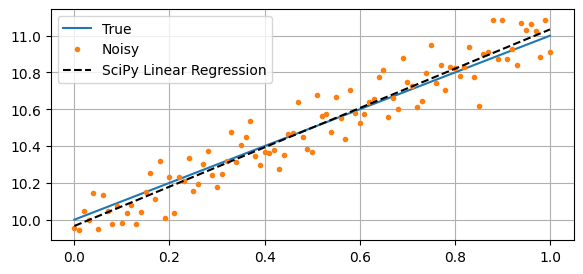

In [3]:
res = sc.stats.linregress(x=x, y=y_noise)  # result object
a_fit = res.slope  # fitted slope
b_fit = res.intercept  # fitted y-intercept

# # add confidence interval
# dof = len(x) - 2 # degrees of freedom
# alpha = 0.05 # probability of confidence interval
# tinv = abs(sc.stats.distributions.t.ppf(alpha/2.0, dof)) # Two-sided inverse Students t-distribution
# a_fit_ci = tinv * res.stderr
# b_fit_ci = tinv * res.intercept_stderr
# lower_bound = (a_fit - a_fit_ci) * x + b_fit - b_fit_ci
# upper_bound = (a_fit + a_fit_ci) * x + b_fit + b_fit_ci

# visualize scipy result
fig, ax = plt.subplots(figsize=(6.75, 3.0))
ax.plot(x, y, label="True")
ax.plot(x, y_noise, marker=".", linestyle="", label="Noisy")
ax.plot(
    x, a_fit * x + b_fit, color="k", linestyle="--", label="SciPy Linear Regression"
)
# ax.fill_between(x, lower_bound, upper_bound, color="k", alpha=0.2, label=f"{1-alpha:0.0%} Confidence Interval")
ax.legend()
ax.grid()

## Pest Linear Regression

### Define run function

This function will be called each iteration by PEST++ GLM to create new simulated values.

In [4]:
def run():
    from numpy import linspace
    from pandas import Index, Series, read_csv

    parameters = read_csv("parameters_sel.csv", index_col=0)
    print("parameters view\n", parameters)
    # simulation = read_csv("simulation.csv")
    # x = simulation.index
    x = linspace(0.0, 1.0, 101)
    y = parameters.at["a", "optimal"] * x + parameters.at["b", "optimal"]
    simulation_new = Series(y, index=Index(x, name="x"), name="Simulation")
    simulation_new.to_csv("simulation.csv")


### Setup PEST++ GLM files with Pyemu

In [5]:
# setup directories
model_dir = Path("model")
model_dir.mkdir() if not model_dir.exists() else None
temp_dir = Path("template")
temp_dir.mkdir() if not temp_dir.exists() else None
bin_dir = Path("bin")

# parameter bounds
bound = 10.0
a_ini = 0.8
b_ini = 0.2
parameters = pd.DataFrame(
    {
        "optimal": [a, b],
        "pmin": [a - bound, b - bound],
        "pmax": [a + bound, b + bound],
        "initial": [a_ini, b_ini],
    },
    index=pd.Index(["a", "b"], name="parnames"),
    dtype=float,
)
# setup files
par_sel = parameters.loc[:, ["optimal"]]
par_sel.to_csv(model_dir / "parameters_sel.csv")

observations = pd.Series(y_noise, index=pd.Index(x, name="x"), name="Observations")
observations.to_csv(model_dir / "simulation.csv")

# create pest optimization with pyemu
pf = pyemu.utils.PstFrom(original_d=model_dir, new_d=temp_dir, remove_existing=True)
# parameters
pf.add_parameters(
    "parameters_sel.csv",
    index_cols=[par_sel.index.name],
    use_cols=par_sel.columns.to_list(),
    par_type="grid",
    par_style="d",
)
# observations
pf.add_observations(
    "simulation.csv", index_cols=[observations.index.name], use_cols=[observations.name]
)
# python scripts to run
pf.add_py_function(
    file_name=run, call_str="run()", is_pre_cmd=None
)
pf.mod_py_cmds.append("run()")

# create control file
pst = pf.build_pst()
pst.parameter_data.loc[:, ["parlbnd", "parubnd"]] = parameters.loc[
    :, ["pmin", "pmax"]
].values  # parameter bounds
pst.parameter_data["partrans"] = "none" # parameter transformation not logarithmic
pst.control_data.noptmax = 100  # optimization runs
pst.write(pf.new_d / "pest.pst", version=2)

# execute
executable = "pestpp-glm"
shutil.copy(bin_dir / executable, temp_dir)
pyemu.os_utils.run(f"{executable} pest.pst", cwd=pf.new_d)

# get pets results
ipar = pd.read_csv(temp_dir / "pest.ipar", index_col=0).transpose()
a_pest, b_pest = ipar.iloc[:, -1].values

2025-01-15 09:45:26.270757 starting: opening PstFrom.log for logging
2025-01-15 09:45:26.271376 starting PstFrom process
2025-01-15 09:45:26.271476 starting: setting up dirs
2025-01-15 09:45:26.271587 starting: removing existing new_d 'template'
2025-01-15 09:45:26.275952 finished: removing existing new_d 'template' took: 0:00:00.004365
2025-01-15 09:45:26.276048 starting: copying original_d 'model' to new_d 'template'
2025-01-15 09:45:26.276991 finished: copying original_d 'model' to new_d 'template' took: 0:00:00.000943
2025-01-15 09:45:26.277687 finished: setting up dirs took: 0:00:00.006211
2025-01-15 09:45:26.277991 transform was not passed, setting default tranform to 'log'
2025-01-15 09:45:26.278262 starting: adding grid type d style parameters for file(s) ['parameters_sel.csv']
2025-01-15 09:45:26.278496 starting: loading list-style template/parameters_sel.csv
2025-01-15 09:45:26.278616 starting: reading list-style file: template/parameters_sel.csv
2025-01-15 09:45:26.281684 fi

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/logger.py:100: PyemuWarning: 2025-01-15 09:45:26.322414 WARNING: add_py_function() command: run() is not being called directly

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:27.638401
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:27.661345
starting arr mlt 2025-01-15 09:45:27.661388
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:27.661608
parameters view
           optimal
parnames         
a             1.0
b            10.0
...exit_code: 32057
...status: 0
01/15/25 09:45:27 forward run command(s) finished, took 1.442 seconds
01/15/25 09:45:27 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:27 done, took 0.001 seconds


-->01/15/25 09:45:27 run complete, took: 1.445 seconds
-->1 of 3 complete, 0 failed


01/15/25 09:45:27 processing template files with 1 threads...
01/15/25 09:45:27 done, took 0 seconds
01/15/25 09:45:27 calling for

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:29.204613
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:29.223943
starting arr mlt 2025-01-15 09:45:29.224014
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:29.224251
parameters view
           optimal
parnames         
a             1.0
b            10.1
...exit_code: 32083
...status: 0
01/15/25 09:45:29 forward run command(s) finished, took 1.543 seconds
01/15/25 09:45:29 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:29 done, took 0 seconds


-->01/15/25 09:45:29 run complete, took: 1.545 seconds
-->2 of 3 complete, 0 failed


01/15/25 09:45:29 processing template files with 1 threads...
01/15/25 09:45:29 done, took 0 seconds
01/15/25 09:45:29 calling forward

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:30.527973
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:30.544766
starting arr mlt 2025-01-15 09:45:30.544818
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:30.545048
parameters view
           optimal
parnames         
a            1.01
b           10.00
...exit_code: 32113
...status: 0
01/15/25 09:45:30 forward run command(s) finished, took 1.314 seconds
01/15/25 09:45:30 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:30 done, took 0 seconds


-->01/15/25 09:45:30 run complete, took: 1.315 seconds
-->3 of 3 complete, 0 failed





    ---  serial run manager runs summary:  ---    
    3 of 3 complete, 0 failed
    process took : 4.307 seconds




  computing u

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:31.886445
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:31.904588
starting arr mlt 2025-01-15 09:45:31.904633
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:31.904810
parameters view
            optimal
parnames          
a         1.067234
b         9.966283
...exit_code: 32133
...status: 0
01/15/25 09:45:32 forward run command(s) finished, took 1.385 seconds
01/15/25 09:45:32 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:32 done, took 0 seconds


-->01/15/25 09:45:32 run complete, took: 1.387 seconds
-->1 of 10 complete, 0 failed


01/15/25 09:45:32 processing template files with 1 threads...
01/15/25 09:45:32 done, took 0 seconds
01/15/25 09:45:32 calling fo

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:33.300338
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:33.319778
starting arr mlt 2025-01-15 09:45:33.319837
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:33.320118
parameters view
            optimal
parnames          
a         1.050426
b         9.974712
...exit_code: 32159
...status: 0
01/15/25 09:45:33 forward run command(s) finished, took 1.428 seconds
01/15/25 09:45:33 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:33 done, took 0 seconds


-->01/15/25 09:45:33 run complete, took: 1.43 seconds
-->2 of 10 complete, 0 failed


01/15/25 09:45:33 processing template files with 1 threads...
01/15/25 09:45:33 done, took 0 seconds
01/15/25 09:45:33 calling for

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:34.760953
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:34.777946
starting arr mlt 2025-01-15 09:45:34.777997
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:34.778219
parameters view
            optimal
parnames          
a         1.059552
b         9.970384
...exit_code: 32186
...status: 0
01/15/25 09:45:34 forward run command(s) finished, took 1.403 seconds
01/15/25 09:45:34 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:34 done, took 0 seconds


-->01/15/25 09:45:34 run complete, took: 1.405 seconds
-->3 of 10 complete, 0 failed


01/15/25 09:45:34 processing template files with 1 threads...
01/15/25 09:45:34 done, took 0 seconds
01/15/25 09:45:34 calling fo

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:36.077050
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:36.094323
starting arr mlt 2025-01-15 09:45:36.094365
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:36.094548
parameters view
            optimal
parnames          
a         1.044664
b         9.977788
...exit_code: 32210
...status: 0
01/15/25 09:45:36 forward run command(s) finished, took 1.314 seconds
01/15/25 09:45:36 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:36 done, took 0 seconds


-->01/15/25 09:45:36 run complete, took: 1.316 seconds
-->4 of 10 complete, 0 failed


01/15/25 09:45:36 processing template files with 1 threads...
01/15/25 09:45:36 done, took 0 seconds
01/15/25 09:45:36 calling fo

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:37.489276
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:37.507173
starting arr mlt 2025-01-15 09:45:37.507224
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:37.507483
parameters view
            optimal
parnames          
a         1.028045
b         9.987120
...exit_code: 32236
...status: 0
01/15/25 09:45:37 forward run command(s) finished, took 1.427 seconds
01/15/25 09:45:37 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:37 done, took 0 seconds


-->01/15/25 09:45:37 run complete, took: 1.429 seconds
-->5 of 10 complete, 0 failed


01/15/25 09:45:37 processing template files with 1 threads...
01/15/25 09:45:37 done, took 0 seconds
01/15/25 09:45:37 calling fo

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:38.891012
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:38.915897
starting arr mlt 2025-01-15 09:45:38.915954
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:38.916196
parameters view
            optimal
parnames          
a         1.021034
b         9.990340
...exit_code: 32262
...status: 0
01/15/25 09:45:39 forward run command(s) finished, took 1.413 seconds
01/15/25 09:45:39 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:39 done, took 0 seconds


-->01/15/25 09:45:39 run complete, took: 1.415 seconds
-->6 of 10 complete, 0 failed


01/15/25 09:45:39 processing template files with 1 threads...
01/15/25 09:45:39 done, took 0 seconds
01/15/25 09:45:39 calling fo

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:40.323710
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:40.342450
starting arr mlt 2025-01-15 09:45:40.342498
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:40.342736
parameters view
            optimal
parnames          
a         1.004806
b         9.998726
...exit_code: 32286
...status: 0
01/15/25 09:45:40 forward run command(s) finished, took 1.463 seconds
01/15/25 09:45:40 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:40 done, took 0 seconds


-->01/15/25 09:45:40 run complete, took: 1.465 seconds
-->7 of 10 complete, 0 failed


01/15/25 09:45:40 processing template files with 1 threads...
01/15/25 09:45:40 done, took 0 seconds
01/15/25 09:45:40 calling fo

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:41.747489
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:41.764126
starting arr mlt 2025-01-15 09:45:41.764176
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:41.764428
parameters view
            optimal
parnames          
a         1.003605
b         9.999044
...exit_code: 32312
...status: 0
01/15/25 09:45:41 forward run command(s) finished, took 1.374 seconds
01/15/25 09:45:41 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:41 done, took 0 seconds


-->01/15/25 09:45:41 run complete, took: 1.376 seconds
-->8 of 10 complete, 0 failed


01/15/25 09:45:41 processing template files with 1 threads...
01/15/25 09:45:41 done, took 0 seconds
01/15/25 09:45:41 calling fo

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:43.103330
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:43.120733
starting arr mlt 2025-01-15 09:45:43.120779
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:43.121027
parameters view
            optimal
parnames          
a         1.000562
b         9.999962
...exit_code: 32338
...status: 0
01/15/25 09:45:43 forward run command(s) finished, took 1.335 seconds
01/15/25 09:45:43 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:43 done, took 0 seconds


-->01/15/25 09:45:43 run complete, took: 1.337 seconds
-->9 of 10 complete, 0 failed


01/15/25 09:45:43 processing template files with 1 threads...
01/15/25 09:45:43 done, took 0 seconds
01/15/25 09:45:43 calling fo

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:44.473629
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:44.492586
starting arr mlt 2025-01-15 09:45:44.492636
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:44.492910
parameters view
            optimal
parnames          
a         1.000421
b         9.999972
...exit_code: 32358
...status: 0
01/15/25 09:45:44 forward run command(s) finished, took 1.458 seconds
01/15/25 09:45:44 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:44 done, took 0.001 seconds


-->01/15/25 09:45:44 run complete, took: 1.46 seconds
-->10 of 10 complete, 0 failed





    ---  serial run manager runs summary:  ---    
    10 of 10 complete, 0 failed
    process took : 14.027 seconds




 

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:46.016586
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:46.034491
starting arr mlt 2025-01-15 09:45:46.034577
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:46.034854
parameters view
            optimal
parnames          
a         1.077907
b         9.966283
...exit_code: 32392
...status: 0
01/15/25 09:45:46 forward run command(s) finished, took 1.505 seconds
01/15/25 09:45:46 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:46 done, took 0 seconds


-->01/15/25 09:45:46 run complete, took: 1.507 seconds
-->1 of 2 complete, 0 failed


01/15/25 09:45:46 processing template files with 1 threads...
01/15/25 09:45:46 done, took 0 seconds
01/15/25 09:45:46 calling for

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:47.449495
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:47.466795
starting arr mlt 2025-01-15 09:45:47.466848
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:47.467103
parameters view
             optimal
parnames           
a          1.067234
b         10.065946
...exit_code: 32461
...status: 0
01/15/25 09:45:47 forward run command(s) finished, took 1.387 seconds
01/15/25 09:45:47 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:47 done, took 0 seconds


-->01/15/25 09:45:47 run complete, took: 1.389 seconds
-->2 of 2 complete, 0 failed





    ---  serial run manager runs summary:  ---    
    2 of 2 complete, 0 failed
    process took : 2.896 seconds




  com

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:48.926127
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:48.952572
starting arr mlt 2025-01-15 09:45:48.952650
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:48.952971
parameters view
            optimal
parnames          
a         1.068200
b         9.965768
...exit_code: 32481
...status: 0
01/15/25 09:45:49 forward run command(s) finished, took 1.498 seconds
01/15/25 09:45:49 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:49 done, took 0 seconds


-->01/15/25 09:45:49 run complete, took: 1.5 seconds
-->1 of 10 complete, 0 failed


01/15/25 09:45:49 processing template files with 1 threads...
01/15/25 09:45:49 done, took 0 seconds
01/15/25 09:45:49 calling forw

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:50.356345
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:50.373787
starting arr mlt 2025-01-15 09:45:50.373834
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:50.374068
parameters view
            optimal
parnames          
a         1.067958
b         9.965896
...exit_code: 32511
...status: 0
01/15/25 09:45:50 forward run command(s) finished, took 1.385 seconds
01/15/25 09:45:50 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:50 done, took 0.001 seconds


-->01/15/25 09:45:50 run complete, took: 1.388 seconds
-->2 of 10 complete, 0 failed


01/15/25 09:45:50 processing template files with 1 threads...
01/15/25 09:45:50 done, took 0 seconds
01/15/25 09:45:50 callin

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:51.807405
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:51.829855
starting arr mlt 2025-01-15 09:45:51.829912
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:51.830250
parameters view
            optimal
parnames          
a         1.068088
b         9.965827
...exit_code: 32537
...status: 0
01/15/25 09:45:52 forward run command(s) finished, took 1.512 seconds
01/15/25 09:45:52 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:52 done, took 0.001 seconds


-->01/15/25 09:45:52 run complete, took: 1.514 seconds
-->3 of 10 complete, 0 failed


01/15/25 09:45:52 processing template files with 1 threads...
01/15/25 09:45:52 done, took 0 seconds
01/15/25 09:45:52 callin

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:52.519191
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:52.539678
starting arr mlt 2025-01-15 09:45:52.539735
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:52.539980
parameters view
            optimal
parnames          
a         1.067874
b         9.965941
...exit_code: 32560
...status: 0
01/15/25 09:45:52 forward run command(s) finished, took 0.669 seconds
01/15/25 09:45:52 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:52 done, took 0.001 seconds


-->01/15/25 09:45:52 run complete, took: 0.672 seconds
-->4 of 10 complete, 0 failed


01/15/25 09:45:52 processing template files with 1 threads...
01/15/25 09:45:52 done, took 0 seconds
01/15/25 09:45:52 callin

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:53.990760
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:54.012262
starting arr mlt 2025-01-15 09:45:54.012346
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:54.012583
parameters view
            optimal
parnames          
a         1.067630
b         9.966073
...exit_code: 32583
...status: 0
01/15/25 09:45:54 forward run command(s) finished, took 1.443 seconds
01/15/25 09:45:54 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:54 done, took 0.001 seconds


-->01/15/25 09:45:54 run complete, took: 1.446 seconds
-->5 of 10 complete, 0 failed


01/15/25 09:45:54 processing template files with 1 threads...
01/15/25 09:45:54 done, took 0 seconds
01/15/25 09:45:54 callin

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:55.443452
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:55.461585
starting arr mlt 2025-01-15 09:45:55.461624
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:55.461892
parameters view
            optimal
parnames          
a         1.067531
b         9.966125
...exit_code: 32613
...status: 0
01/15/25 09:45:55 forward run command(s) finished, took 1.446 seconds
01/15/25 09:45:55 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:55 done, took 0 seconds


-->01/15/25 09:45:55 run complete, took: 1.448 seconds
-->6 of 10 complete, 0 failed


01/15/25 09:45:55 processing template files with 1 threads...
01/15/25 09:45:55 done, took 0 seconds
01/15/25 09:45:55 calling fo

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:56.875164
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:56.893490
starting arr mlt 2025-01-15 09:45:56.893545
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:56.893753
parameters view
            optimal
parnames          
a         1.067297
b         9.966251
...exit_code: 32639
...status: 0
01/15/25 09:45:57 forward run command(s) finished, took 1.442 seconds
01/15/25 09:45:57 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:57 done, took 0 seconds


-->01/15/25 09:45:57 run complete, took: 1.444 seconds
-->7 of 10 complete, 0 failed


01/15/25 09:45:57 processing template files with 1 threads...
01/15/25 09:45:57 done, took 0 seconds
01/15/25 09:45:57 calling fo

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:58.279420
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:58.298890
starting arr mlt 2025-01-15 09:45:58.298964
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:58.299318
parameters view
            optimal
parnames          
a         1.067281
b         9.966259
...exit_code: 32659
...status: 0
01/15/25 09:45:58 forward run command(s) finished, took 1.442 seconds
01/15/25 09:45:58 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:58 done, took 0 seconds


-->01/15/25 09:45:58 run complete, took: 1.443 seconds
-->8 of 10 complete, 0 failed


01/15/25 09:45:58 processing template files with 1 threads...
01/15/25 09:45:58 done, took 0 seconds
01/15/25 09:45:58 calling fo

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:45:59.689478
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:45:59.711241
starting arr mlt 2025-01-15 09:45:59.711289
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:45:59.711518
parameters view
            optimal
parnames          
a         1.067241
b         9.966280
...exit_code: 32689
...status: 0
01/15/25 09:45:59 forward run command(s) finished, took 1.388 seconds
01/15/25 09:45:59 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:45:59 done, took 0 seconds


-->01/15/25 09:45:59 run complete, took: 1.39 seconds
-->9 of 10 complete, 0 failed


01/15/25 09:45:59 processing template files with 1 threads...
01/15/25 09:45:59 done, took 0 seconds
01/15/25 09:45:59 calling for

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:46:01.041017
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:46:01.057810
starting arr mlt 2025-01-15 09:46:01.057849
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:46:01.058045
parameters view
            optimal
parnames          
a         1.067239
b         9.966281
...exit_code: 32715
...status: 0
01/15/25 09:46:01 forward run command(s) finished, took 1.316 seconds
01/15/25 09:46:01 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:46:01 done, took 0 seconds


-->01/15/25 09:46:01 run complete, took: 1.318 seconds
-->10 of 10 complete, 0 failed





    ---  serial run manager runs summary:  ---    
    10 of 10 complete, 0 failed
    process took : 13.57 seconds




  tes

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:46:02.392115
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:46:02.409113
starting arr mlt 2025-01-15 09:46:02.409162
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:46:02.409445
parameters view
            optimal
parnames          
a         1.046836
b         9.965768
...exit_code: 32735
...status: 0
01/15/25 09:46:02 forward run command(s) finished, took 1.337 seconds
01/15/25 09:46:02 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:46:02 done, took 0 seconds


-->01/15/25 09:46:02 run complete, took: 1.338 seconds
-->1 of 4 complete, 0 failed


01/15/25 09:46:02 processing template files with 1 threads...
01/15/25 09:46:02 done, took 0 seconds
01/15/25 09:46:02 calling for

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:46:03.881876
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:46:03.898378
starting arr mlt 2025-01-15 09:46:03.898429
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:46:03.898672
parameters view
            optimal
parnames          
a         1.089564
b         9.965768
...exit_code: 32761
...status: 0
01/15/25 09:46:04 forward run command(s) finished, took 1.482 seconds
01/15/25 09:46:04 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:46:04 done, took 0.001 seconds


-->01/15/25 09:46:04 run complete, took: 1.484 seconds
-->2 of 4 complete, 0 failed


01/15/25 09:46:04 processing template files with 1 threads...
01/15/25 09:46:04 done, took 0 seconds
01/15/25 09:46:04 calling

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:46:05.178735
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:46:05.196141
starting arr mlt 2025-01-15 09:46:05.196180
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:46:05.196374
parameters view
            optimal
parnames          
a         1.068200
b         9.766452
...exit_code: 32791
...status: 0
01/15/25 09:46:05 forward run command(s) finished, took 1.285 seconds
01/15/25 09:46:05 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:46:05 done, took 0 seconds


-->01/15/25 09:46:05 run complete, took: 1.287 seconds
-->3 of 4 complete, 0 failed


01/15/25 09:46:05 processing template files with 1 threads...
01/15/25 09:46:05 done, took 0 seconds
01/15/25 09:46:05 calling for

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:46:06.561187
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:46:06.585091
starting arr mlt 2025-01-15 09:46:06.585157
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:46:06.585342
parameters view
             optimal
parnames           
a          1.068200
b         10.165083
...exit_code: 32811
...status: 0
01/15/25 09:46:06 forward run command(s) finished, took 1.388 seconds
01/15/25 09:46:06 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:46:06 done, took 0 seconds


-->01/15/25 09:46:06 run complete, took: 1.39 seconds
-->4 of 4 complete, 0 failed





    ---  serial run manager runs summary:  ---    
    4 of 4 complete, 0 failed
    process took : 5.502 seconds




  comp

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:46:08.088740
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:46:08.105651
starting arr mlt 2025-01-15 09:46:08.105694
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:46:08.105946
parameters view
            optimal
parnames          
a         1.068213
b         9.965760
...exit_code: 32837
...status: 0
01/15/25 09:46:08 forward run command(s) finished, took 1.5 seconds
01/15/25 09:46:08 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:46:08 done, took 0 seconds


-->01/15/25 09:46:08 run complete, took: 1.502 seconds
-->1 of 10 complete, 0 failed


01/15/25 09:46:08 processing template files with 1 threads...
01/15/25 09:46:08 done, took 0 seconds
01/15/25 09:46:08 calling forw

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:46:09.474602
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:46:09.491795
starting arr mlt 2025-01-15 09:46:09.491833
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:46:09.492054
parameters view
            optimal
parnames          
a         1.068210
b         9.965762
...exit_code: 32863
...status: 0
01/15/25 09:46:09 forward run command(s) finished, took 1.381 seconds
01/15/25 09:46:09 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:46:09 done, took 0.001 seconds


-->01/15/25 09:46:09 run complete, took: 1.383 seconds
-->2 of 10 complete, 0 failed


01/15/25 09:46:09 processing template files with 1 threads...
01/15/25 09:46:09 done, took 0 seconds
01/15/25 09:46:09 callin

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:46:10.753318
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:46:10.770252
starting arr mlt 2025-01-15 09:46:10.770301
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:46:10.770569
parameters view
            optimal
parnames          
a         1.068212
b         9.965761
...exit_code: 32887
...status: 0
01/15/25 09:46:10 forward run command(s) finished, took 1.281 seconds
01/15/25 09:46:10 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:46:10 done, took 0.001 seconds


-->01/15/25 09:46:10 run complete, took: 1.284 seconds
-->3 of 10 complete, 0 failed


01/15/25 09:46:10 processing template files with 1 threads...
01/15/25 09:46:10 done, took 0 seconds
01/15/25 09:46:10 callin

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:46:12.045869
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:46:12.064579
starting arr mlt 2025-01-15 09:46:12.064620
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:46:12.064807
parameters view
            optimal
parnames          
a         1.068209
b         9.965763
...exit_code: 32913
...status: 0
01/15/25 09:46:12 forward run command(s) finished, took 1.297 seconds
01/15/25 09:46:12 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:46:12 done, took 0 seconds


-->01/15/25 09:46:12 run complete, took: 1.3 seconds
-->4 of 10 complete, 0 failed


01/15/25 09:46:12 processing template files with 1 threads...
01/15/25 09:46:12 done, took 0 seconds
01/15/25 09:46:12 calling forw

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:46:13.354441
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:46:13.372820
starting arr mlt 2025-01-15 09:46:13.372872
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:46:13.373126
parameters view
            optimal
parnames          
a         1.068205
b         9.965764
...exit_code: 32939
...status: 0
01/15/25 09:46:13 forward run command(s) finished, took 1.354 seconds
01/15/25 09:46:13 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:46:13 done, took 0 seconds


-->01/15/25 09:46:13 run complete, took: 1.356 seconds
-->5 of 10 complete, 0 failed


01/15/25 09:46:13 processing template files with 1 threads...
01/15/25 09:46:13 done, took 0 seconds
01/15/25 09:46:13 calling fo

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:46:14.732741
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:46:14.749824
starting arr mlt 2025-01-15 09:46:14.749889
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:46:14.750179
parameters view
            optimal
parnames          
a         1.068204
b         9.965765
...exit_code: 32966
...status: 0
01/15/25 09:46:14 forward run command(s) finished, took 1.355 seconds
01/15/25 09:46:14 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:46:14 done, took 0 seconds


-->01/15/25 09:46:14 run complete, took: 1.357 seconds
-->6 of 10 complete, 0 failed


01/15/25 09:46:14 processing template files with 1 threads...
01/15/25 09:46:14 done, took 0 seconds
01/15/25 09:46:14 calling fo

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:46:16.103902
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:46:16.120677
starting arr mlt 2025-01-15 09:46:16.120730
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:46:16.120989
parameters view
            optimal
parnames          
a         1.068200
b         9.965767
...exit_code: 32992
...status: 0
01/15/25 09:46:16 forward run command(s) finished, took 1.366 seconds
01/15/25 09:46:16 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:46:16 done, took 0 seconds


-->01/15/25 09:46:16 run complete, took: 1.368 seconds
-->7 of 10 complete, 0 failed


01/15/25 09:46:16 processing template files with 1 threads...
01/15/25 09:46:16 done, took 0 seconds
01/15/25 09:46:16 calling fo

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:46:17.451841
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:46:17.469301
starting arr mlt 2025-01-15 09:46:17.469351
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:46:17.469602
parameters view
            optimal
parnames          
a         1.068200
b         9.965767
...exit_code: 33015
...status: 0
01/15/25 09:46:17 forward run command(s) finished, took 1.323 seconds
01/15/25 09:46:17 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:46:17 done, took 0.001 seconds


-->01/15/25 09:46:17 run complete, took: 1.326 seconds
-->8 of 10 complete, 0 failed


01/15/25 09:46:17 processing template files with 1 threads...
01/15/25 09:46:17 done, took 0 seconds
01/15/25 09:46:17 callin

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:46:19.021982
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:46:19.048679
starting arr mlt 2025-01-15 09:46:19.048726
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:46:19.048999
parameters view
            optimal
parnames          
a         1.068200
b         9.965768
...exit_code: 33038
...status: 0
01/15/25 09:46:19 forward run command(s) finished, took 1.648 seconds
01/15/25 09:46:19 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:46:19 done, took 0 seconds


-->01/15/25 09:46:19 run complete, took: 1.65 seconds
-->9 of 10 complete, 0 failed


01/15/25 09:46:19 processing template files with 1 threads...
01/15/25 09:46:19 done, took 0 seconds
01/15/25 09:46:19 calling for

/home/martin/repos/pastas-plugins/.venv/lib/python3.12/site-packages/pyemu/__init__.py:29: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


error removing tmp file:simulation.csv
starting list mlt 2025-01-15 09:46:20.544539
number of chunks to process: 1
null mlt file for org_file 'org/parameters_sel.csv', continuing...
process 0  processed  1 process_list_file calls
finished list mlt 2025-01-15 09:46:20.562522
starting arr mlt 2025-01-15 09:46:20.562566
number of chunks to process: 1
process 0  processed  0 process_array_file calls
finished arr mlt 2025-01-15 09:46:20.562792
parameters view
            optimal
parnames          
a         1.068200
b         9.965768
...exit_code: 33071
...status: 0
01/15/25 09:46:20 forward run command(s) finished, took 1.437 seconds
01/15/25 09:46:20 processing instruction files with 1 threads...
thread 0 processed 1 instruction files
01/15/25 09:46:20 done, took 0.001 seconds


-->01/15/25 09:46:20 run complete, took: 1.439 seconds
-->10 of 10 complete, 0 failed





    ---  serial run manager runs summary:  ---    
    10 of 10 complete, 0 failed
    process took : 13.972 seconds






## Compare result

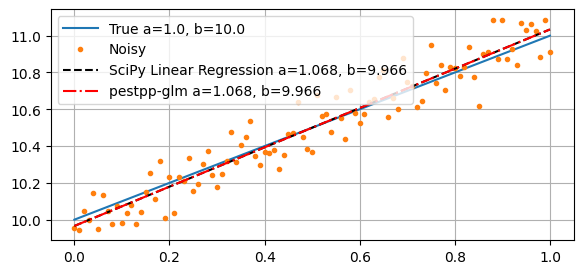

In [6]:
fig, ax = plt.subplots(figsize=(6.75, 3))
ax.plot(x, y, label=f"True {a=}, {b=}")
ax.plot(x, y_noise, marker=".", linestyle="", label="Noisy")
ax.plot(
    x,
    a_fit * x + b_fit,
    color="k",
    linestyle="--",
    label=f"SciPy Linear Regression a={a_fit:0.3f}, b={b_fit:0.3f}",
)
ax.plot(
    x,
    a_pest * x + b_pest,
    color="r",
    linestyle="-.",
    label=f"{executable} a={a_pest:0.3f}, b={b_pest:0.3f}",
)
ax.legend(handlelength=2.5)
ax.grid(True)

## TODO

Add comparison of confidence interval